# Preface
Before I go over the milestone, there is one key change here. In one of my previous versions of this milestone I implemented a neural network to predict the sentiment score of a sentence, this included a fair amount of pre-processing, took 6 hours per training, and had a fiar amount of work. This week when I started the process of building a model for the final predictions - I opted to test out the VADER sentiment analysis and it proved better, so I'll be leveraging that instead of the other model. 

## Step one: Imports
Here I just import a variety of modules and basic things like the paths - then import the dataframe.

In [38]:
import pandas as pd, contractions, nltk, string, torch, torch.nn as nn, torch_directml, torch.optim as optim, numpy as np, torch.nn.functional as F, matplotlib.pyplot as plt, \
 concurrent.futures, itertools
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

base_path = Path()
raw_data = base_path.joinpath('raw_data')
filtered_data = 'filtered_data.json'


In [39]:
filtered_df = pd.read_json(raw_data.joinpath(filtered_data))

## Step 2: Pre-Processing
I initialize the pandas TQDM module and work on pre-processing. Here I tokenize the reviews, replace the contractions for better accuracy, and detokenize it. Lastly I recast the appropriate columns to integers and drop the language column. 

In [40]:
tqdm.pandas()
#tokenize the review and strip punctuation
review_tokenizer = nltk.tokenize.WhitespaceTokenizer()
review_detokenizer = nltk.tokenize.treebank.TreebankWordDetokenizer()
filtered_df['review'] = filtered_df['review'].progress_apply(lambda x: review_tokenizer.tokenize(x))
filtered_df['review'] = filtered_df['review'].progress_apply(lambda x: review_detokenizer.detokenize([(contractions.fix(word.strip(string.punctuation))) for word in x]))
filtered_df[['voted_up', 'received_for_free', 'written_during_early_access']] = filtered_df[['voted_up', 'received_for_free', 'written_during_early_access']].astype(int)
filtered_df.drop(columns='language', inplace=True, axis=1)

  0%|          | 0/114834 [00:00<?, ?it/s]

  0%|          | 0/114834 [00:00<?, ?it/s]

In [41]:
display(filtered_df.head(10))

,ids,recommendationid,voted_up,received_for_free,written_during_early_access,weighted_vote_score,review
0,70,115513013,1,0,0,0.729283,Review of Half-Life Revolutionizing the indust...
1,70,115813617,1,0,0,0.642857,A must play classic
2,70,115817244,1,0,0,0.615385,One of the best games every created still fun ...
3,70,115566933,1,0,0,0.613007,sp is pretty cool deathmatch goes crazy
4,70,116146745,1,0,0,0.583333,I am Kayne West and this is the Kayne best
5,70,116216878,1,0,0,0.565217,1998
6,70,115547553,0,0,0,0.537176,I have come to make an announcement Gordon Fre...
7,70,115619966,1,0,0,0.527528,Yes
8,70,116243034,1,0,0,0.526959,OMFG BEST GRAPHICSSSSSSSSSSSSSS
9,70,115766562,1,0,0,0.525862,very noice game


## Step 3: Sentiment Prediction
First thing here is to set a device variable for using the torch-directml module. This module lets me use my AMD GPU for PyTorch resulting in faster processing times. On occasion I have to use the CPU, but that just depends on specific things.
Afterwards I run the VADER Sentiment Analysis module against the reviews and get the score - then rescale it on a range from 0-1.
After doing this I ran a classification report to see the accuracy of the VADER analyzer, and it got an accuracy of 74%, which beat my previous Neural Network score of 67% (on average), and overall provided a better representation of the sentiments of the reviews.

In [42]:
device = torch_directml.device()
print(device)
temp_df = filtered_df

privateuseone:0


In [43]:
#predicted review sentiments and put them in a new column called nltk_sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk_sentiment = SentimentIntensityAnalyzer()
temp_df['nltk_sentiment'] = temp_df['review'].progress_apply(lambda x: nltk_sentiment.polarity_scores(x)['compound'])
temp_df['nltk_sentiment'] = temp_df['nltk_sentiment'].progress_apply(lambda x: (x+1)/2)

  0%|          | 0/114834 [00:00<?, ?it/s]

  0%|          | 0/114834 [00:00<?, ?it/s]

In [44]:
from sklearn.metrics import classification_report
display(temp_df)
nltk_df = temp_df.copy(deep=True)
print(f'NLTK Classification Report: {classification_report(temp_df["nltk_sentiment"].round(), temp_df["voted_up"])}')

,ids,recommendationid,voted_up,received_for_free,written_during_early_access,weighted_vote_score,review,nltk_sentiment
0,70,115513013,1,0,0,0.729283,Review of Half-Life Revolutionizing the indust...,0.99820
1,70,115813617,1,0,0,0.642857,A must play classic,0.67000
2,70,115817244,1,0,0,0.615385,One of the best games every created still fun ...,0.92955
3,70,115566933,1,0,0,0.613007,sp is pretty cool deathmatch goes crazy,0.73835
4,70,116146745,1,0,0,0.583333,I am Kayne West and this is the Kayne best,0.81845
...,...,...,...,...,...,...,...,...
185129,1453740,93440338,1,0,0,0.476879,ALL HAIL ROACH KING ALL HAIL ROACH KING ALL HA...,0.97370
185130,1453740,107206153,0,0,0,0.389933,I feel like I am an idiot I cannot get my mous...,0.39885
185131,1453740,108880733,1,0,0,0.000000,This Game is Hard As Fuck,0.20030
185287,1203770,61871345,0,0,0,0.621985,I truly do not like giving bad reviews...I rea...,0.35120


NLTK Classification Report:               precision    recall  f1-score   support

         0.0       0.59      0.56      0.57     35968
         1.0       0.80      0.82      0.81     78866

    accuracy                           0.74    114834
   macro avg       0.70      0.69      0.69    114834
weighted avg       0.74      0.74      0.74    114834



In [45]:
temp_df = temp_df.drop('review', axis=1)
display(temp_df)

,ids,recommendationid,voted_up,received_for_free,written_during_early_access,weighted_vote_score,nltk_sentiment
0,70,115513013,1,0,0,0.729283,0.99820
1,70,115813617,1,0,0,0.642857,0.67000
2,70,115817244,1,0,0,0.615385,0.92955
3,70,115566933,1,0,0,0.613007,0.73835
4,70,116146745,1,0,0,0.583333,0.81845
...,...,...,...,...,...,...,...
185129,1453740,93440338,1,0,0,0.476879,0.97370
185130,1453740,107206153,0,0,0,0.389933,0.39885
185131,1453740,108880733,1,0,0,0.000000,0.20030
185287,1203770,61871345,0,0,0,0.621985,0.35120


## Step 4: Generating Datasets
Here I define my dataset class, which sets the methods for how the DataLoader interacts with the data. This includes the len method, getitem method, and it defines the "X" and "Y" values for the dataframe. Afterwards I create my train-test splits, get the dataset, then create a dataloader for them. I also drop N/A values beforehand to prevent issues with training.

In [9]:
class PredictionDataset(Dataset):

    def __init__(self, df, device):
        self.df = df
        self.X = torch.tensor(df[['received_for_free', 'written_during_early_access', 'weighted_vote_score', 'nltk_sentiment']].values, dtype=torch.float32).to(device)
        self.y = torch.tensor(df['voted_up'].values, dtype=torch.int8).to(device)

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
temp_df.dropna(inplace=True)
pred_test_data, pred_train_data = train_test_split(temp_df[['received_for_free', 'written_during_early_access', 'weighted_vote_score', 'nltk_sentiment', 'voted_up']], test_size=0.2, random_state=42)
pred_test_dataset = PredictionDataset(pred_test_data, device)
pred_train_dataset = PredictionDataset(pred_train_data, device)
pred_test_dataloader = torch.utils.data.DataLoader(pred_test_dataset, batch_size=32, shuffle=False)
pred_train_dataloader = torch.utils.data.DataLoader(pred_train_dataset, batch_size=32, shuffle=True)

## Step 5: Defining Model
This time the model is relatively simple.
The model is compirsed of two Linear layers (guesses weights), with a ReLU layer inbetween to add non-linear variation. 
The last layer is a sigmoid layer to cast the final guess on a scale of 0-1, with the final step in the forward method being a rounding step. 
This step will take the final guess and round it to 0 or 1 (for a true guess) with a threshold value. This value is to help improve accuracy, and to help prevent all 0 or all 1 guesses.

In [11]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=1, threshold=0):
        super(BinaryClassifier, self).__init__()
        self.threshold = threshold
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, out):
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = torch.round(out + self.threshold)
        return out

## Step 6: Getting the ideal threshold
Instead of just guessing for the appropriate threshold, I decided to programtically find it. Essentially I do a train-test loop over all threshold values from .001-.05 and find what value yields the best accuracy. To help prevent it from guessing the same value (due to imbalanced classes) I find the threshold that doesn't contain all 0's or 1's, and has the best accuracy.
To prevent each training loop impacting the next one, I reset all applicable parameters for the layers inbetween each iteration.

In [29]:
input_size = pred_train_data.shape[1]-1
output_size = 1
hidden_size = 64
learn_rate = 0.001



def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

pred_model = BinaryClassifier(input_size, hidden_size, output_size)
pred_optimizer = optim.Adam(pred_model.parameters(), lr=learn_rate)
pred_criterion = nn.BCEWithLogitsLoss()
pred_model = pred_model.to(device)

best_threshold = None
best_val_acc = 0
threshold_range = np.arange(0.001, 0.05, 0.001)
for threshold in tqdm(threshold_range, desc='Testing Thresholds'):
    pred_model.apply(weight_reset)
    pred_model.threshold = threshold
    pred_model.train()
    for X_batch, y_batch in pred_train_dataloader:
        pred_optimizer.zero_grad()
        y_pred = pred_model(X_batch)
        loss = pred_criterion(y_pred, y_batch.unsqueeze(1).float())
        loss.backward()
        pred_optimizer.step()
    correct = 0
    total = 0
    y_pred_test_list = []
    pred_model.eval()
    for X_batch, y_batch in pred_test_dataloader:
        y_pred_test = pred_model(X_batch)
        correct += (y_pred_test == y_batch.unsqueeze(1).float()).sum().item()
        total += y_batch.size(0)
        y_pred_test_list += y_pred_test.detach().cpu().numpy().tolist()

    val_acc = correct / total
    
    y_pred_unique = np.unique(y_pred_test_list).shape[0]

    if val_acc > best_val_acc and y_pred_unique > 1:
        best_threshold = threshold
        best_val_acc = val_acc
        best_unique = y_pred_unique

print(f'Best threshold value: {best_threshold} with validation accuracy {best_val_acc} with {best_unique} unique predictions')

Testing Thresholds:   0%|          | 0/49 [00:00<?, ?it/s]

Best threshold value: 0.017 with validation accuracy 0.7140540128664264 with 2 unique predictions


## Step 7: Model Training
Finally I reset the parameters for the last time then set the threshold. This will provide me with the final model results that we can use to make our guesses for the entire dataset at a later stage.

Training:   0%|          | 0/50 [00:00<?, ?it/s]

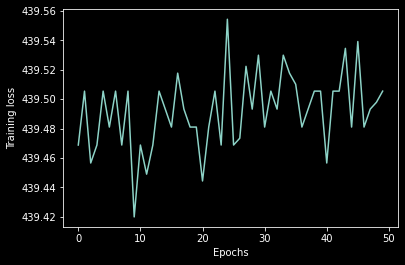

Testing:   0%|          | 0/2871 [00:00<?, ?it/s]

In [ ]:
loss_data = []
# Train the model
pred_model.apply(weight_reset)
pred_model.threshold = best_threshold
epochs = 50
pred_model.train()
for epoch in tqdm(range(epochs), desc='Training', total=epochs):
    train_loss = 0.0
    for X_batch, y_batch in pred_train_dataloader:
        pred_optimizer.zero_grad()
        y_pred = pred_model(X_batch)
        loss = pred_criterion(y_pred, y_batch.unsqueeze(1).float())
        loss.backward()
        pred_optimizer.step()
        train_loss += loss.item()
    loss_data.append(train_loss)

plt.plot(range(epochs), loss_data)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

pred_df = pd.DataFrame()
# Evaluate the model
pred_model.eval()
with torch.no_grad():
    test_loss = 0
    for X_batch, y_batch in tqdm(pred_test_dataloader, desc='Testing', total=len(pred_test_dataloader)):
        y_pred_test = pred_model(X_batch)
        test_loss += pred_criterion(y_pred_test, y_batch.unsqueeze(1).float()).item()
        X_batch = X_batch.to('cpu').numpy()
        y_batch = y_batch.to('cpu').numpy()
        y_pred_test = y_pred_test.to('cpu').detach().numpy()

        # Convert the predictions to a dataframe
        X_batch_df = pd.DataFrame(X_batch, columns=['received_for_free', 'written_during_early_access', 'weighted_vote_score', 'nltk_sentiment'])
        y_batch_df = pd.DataFrame(y_batch, columns=['voted_up'])
        y_pred_test_df = pd.DataFrame(y_pred_test, columns=['pred_voted_up'])

        # Concatenate the dataframes
        pred_df = pd.concat([pred_df, pd.concat([X_batch_df, y_batch_df, y_pred_test_df], axis=1)], axis=0)

## Report
Finally I perform a classification report on the predictions. Here we can see the resulting accuracy of: 70% , and the appropriate value counts (to help debug in the event of unexpected results)

Unforunately the accuracy improvement over the last milestone is the result of predicitons being less diverse and is more weighted into true predictions. Adagrad resulted in more diverse predictions - but the predicitons had a worse accuracy. 

In [ ]:
from sklearn.metrics import classification_report
display(pred_df)
print(f'Pred Value Counts: \n {pred_df["pred_voted_up"].value_counts()} \n \
      Actual Value Counts: \n {pred_df["voted_up"].value_counts()}')
print(f'Classification Report: \n {classification_report(pred_df["pred_voted_up"], pred_df["voted_up"])}')

,received_for_free,written_during_early_access,weighted_vote_score,nltk_sentiment,voted_up,pred_voted_up
0,0.0,0.0,0.518085,0.87895,0,1.0
1,0.0,0.0,0.577248,0.97975,1,1.0
2,0.0,0.0,0.611006,0.92210,1,1.0
3,0.0,1.0,0.631611,0.00310,1,1.0
4,0.0,0.0,0.479876,0.98495,1,1.0
...,...,...,...,...,...,...
22,0.0,1.0,0.469799,0.95615,1,1.0
23,0.0,0.0,0.560642,0.20495,0,1.0
24,0.0,0.0,0.484914,0.75935,1,1.0
25,0.0,0.0,0.523810,0.30910,1,1.0


Pred Value Counts: 
 1.0    91437
0.0      430
Name: pred_voted_up, dtype: int64 
       Actual Value Counts: 
 1    64746
0    27121
Name: voted_up, dtype: int64
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.01      0.34      0.01       430
         1.0       1.00      0.70      0.83     91437

    accuracy                           0.70     91867
   macro avg       0.50      0.52      0.42     91867
weighted avg       0.99      0.70      0.82     91867



In [88]:
import dash, dash_core_components as dcc
from dash.dependencies import Input, Output
from dash import html
import plotly.express as px

app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Review Analysis Dashboard"),
    html.Div([
        html.Label("Enter a Review:"),
        dcc.Textarea(
            id='review-input',
            placeholder="Enter a review...",
            style={'width': '100%'}
        ),
        html.Div([
            dcc.Checklist(id='free-checkbox', options=['Free']),
            dcc.Checklist(id='early-access-checkbox', options=['Early Access']),
            html.Label("Weighted Vote Score:"),
            dcc.Input(id='weighted-vote-score-input', type='number', value=0, min=0, max=1, step=0.001)
    ]),
        html.Button('Predict', id='predict-button', n_clicks=0),
        html.Div(id='prediction-output')
    ])
])

def generate_prediction_tensor(review, free, early_access, weighted_vote_score):
    review = review_tokenizer.tokenize(review)
    review = review_detokenizer.detokenize([(contractions.fix(word.strip(string.punctuation))) for word in review])
    sentiment_score = (nltk_sentiment.polarity_scores(review)['compound']+1)/2
    pred_tensor = torch.tensor([free, early_access, weighted_vote_score, sentiment_score])
    pred_tensor = pred_tensor.to(device)
    return [pred_tensor, sentiment_score]

@app.callback(
    Output('prediction-output', 'children'),
    Input('predict-button', 'n_clicks'),
    Input('review-input', 'value'),
    Input('free-checkbox', 'checked'),
    Input('early-access-checkbox', 'checked'),
    Input('weighted-vote-score-input', 'value')
)
def predict_review(n_clicks, review, free=False, early_access=False, weighted_vote_score=0):
    early_access = 1 if early_access else 0
    free = 1 if free else 0
    if n_clicks > 0 and review:
        # Preprocess the review text (similar to the code snippet provided)
        # Use the preprocessed review text to make a prediction using your trained model
        # Display the prediction result as output
        # You need to modify this part based on your specific model implementation
        pred_tensor, sentiment_score = generate_prediction_tensor(review, free, early_access, weighted_vote_score)
        return f"Prediction: {'Recommended' if pred_model(pred_tensor) else 'Not Recommended'} \
        with a sentiment score of {sentiment_score}"
    return ""

In [89]:
app.run()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


[2023-06-04 00:28:13,879] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\flask\app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\dash\dash.py", line 1249, in dispatch
    ctx.run(
  File "c:\Users\sebas\AppData\Local\Programs\Pytho